In [2]:
import numpy as np     
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Content:
This file is to invertigate the reduction of HG33 mode loss by rotating the maps as well as increasing astigmatism. Including:
1. The loss of the original maps vs. rotated maps
2. The loss of different amount of astigmatism added before the rotation
3. The random maps needed for the contrast defect task, see file 'Contrast defect with rotated maps and more astigmatism.ipynb'

In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
fig = plt.figure(figsize=plt.figaspect(0.333))

ax = fig.add_subplot(1, 3, 1, projection='3d')
# Make data.
X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(X, Y)
rho = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)
Z22map = rho**2*np.cos(2*phi)
Z2_2map = rho**2*np.sin(2*phi)

# Plot the surface.
ax.plot_surface(X, Y, 0.7*Z22map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('$Z_{2}^{2}$')

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, Y, 0.3*Z2_2map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('$Z_{2}^{-2}$')

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(X, Y, 0.7*Z22map+0.3*Z2_2map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('0.7*$Z_{2}^{2}$ + 0.3*$Z_{2}^{2}$')
plt.show()

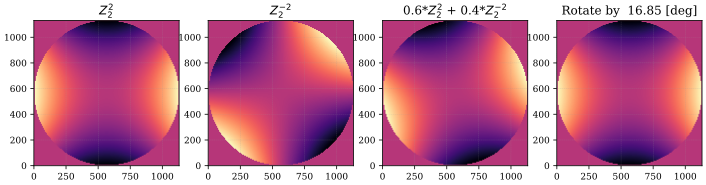

In [17]:
# Show an example of this rotation

fig, ax1 = plt.subplots(1,4, figsize=(12,3))
ax1[0].imshow(Z22)
ax1[0].set_title('$Z_{2}^{2}$')
ax1[1].imshow(Z2_2)
ax1[1].set_title('$Z_{2}^{-2}$')
ax1[2].imshow(0.6*Z22+0.4*Z2_2)
ax1[2].set_title('0.6*$Z_{2}^{2}$ + 0.4*$Z_{2}^{-2}$')

ii = 0.4
jj = 0.6
Data1 = ii*Z2_2 + jj*Z22
phi = np.arctan(ii/jj)/2 # calculate the rotation angle from the coefficients
radius = int(round(0.15/0.0002669951063580811))

Data2 = np.zeros((1131, 1131))
for i in range(1131):
    for j in range(1131):
        if (i-565)**2+(j-565)**2 <= radius**2:
            if jj<0:
                x = int(round((j-565)*np.cos(phi)-(i-565)*np.sin(phi)))+565 # Rotate the maps
                y = int(round((j-565)*np.sin(phi)+(i-565)*np.cos(phi)))+565
            else: 
                x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
            Data2[i][j] = Data1[x][y]
        else:
            Data2[i][j] = 0

ax1[3].imshow(Data2)
ax1[3].set_title(f'Rotate by {(phi*180/np.pi): .2f} [deg]')
plt.show()

In [2]:
# This is used when generating the rotated maps

def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('temp.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('temp.txt',originalfile)

def mapfileHeader(filename, mapdata):
    with open('Znmmaps/Z00order1phasemap.txt') as myfile: # take the header from the aLIGO measured map
        head = [next(myfile) for x in range(9)]
    header="".join(head)

    np.savetxt(filename, mapdata, delimiter=' ',fmt='%1.4f')
    insert(filename,f'''{header}''')

# Basis to calculate the zernike coefficients
Z2_2 = pd.read_csv('Znmmaps/Z2-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
Z22 = pd.read_csv('Znmmaps/Z22order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

In [21]:
# Some examples of all posible cases: positive A_{22} positive A_{2-2}, positive A_{22} negative A_{2-2}, 
# negative A_{22} positive A_{2-2}, negative A_{22} negative A_{2-2}. To make sure the rotation function is indeed working.
mapData1 = []
mapData2 = []

for ii in np.random.rand(7)-0.5:
    print(f'i:{ii}')
    jj = np.random.rand(1)[0]-0.5
    print(f'j:{jj}')
    Data1 = ii*Z2_2 + jj*Z22
    mapData1.append(Data1)
    phi = np.arctan(ii/jj)/2
    radius = 0.15/0.0002669951063580811
    
    Data2 = np.zeros((1131, 1131))
    for i in range(1131):
        for j in range(1131):
            if (i-565)**2+(j-565)**2 <= radius**2:
                if jj<0:
                    x = int(round((j-565)*np.cos(phi)+(i-565)*np.sin(phi)))+565
                    y = int(round(-(j-565)*np.sin(phi)+(i-565)*np.cos(phi)))+565
                else: 
                    x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                    y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
                Data2[i][j] = Data1[x][y]
            else:
                Data2[i][j] = 0
    mapData2.append(Data2)

i:-0.34545738948302485
j:0.3914198391443485
i:-0.3744162071621777
j:0.010035784645860857
i:-0.4646700766450024
j:-0.14037936772819548
i:-0.17524505761117926
j:0.4529560431642694
i:-0.04332997024279717
j:-0.3556611527364095
i:0.12266880879583275
j:0.07014685949284083
i:0.11683361843419038
j:-0.467476984652616


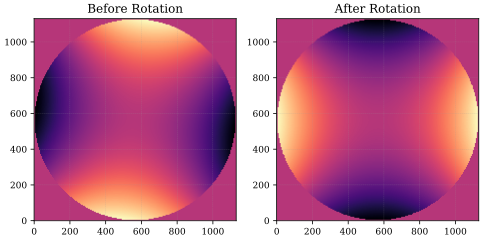

In [25]:
# Here is to plot the original maps and rotated maps, and for all cases the rotation is working properly.
fig, ax1 = plt.subplots(1,2, figsize=(8,6))
i = 6
ax1[0].imshow(mapData1[i])
ax1[0].set_title('Before Rotation')
ax1[1].imshow(mapData2[i])
ax1[1].set_title('After Rotation')
plt.show()

### Rotate the random maps

In [6]:
# Rotate random maps according to Z2-2 and Z22

# find the Z22 and Z2-2 content and calculate the rotation angle
Z2_2 = pd.read_csv('Znmmaps/Z2-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
Z22 = pd.read_csv('Znmmaps/Z22order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

mapData2 = []
for ii in range(50):
    # Read in the random maps
    mapData1 = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
    
    # Calculate the zernike coefficients and the angle
    A2_2 = ((mapData1*Z2_2).sum())/((Z2_2*Z2_2).sum())
    A22 = ((mapData1*Z22).sum())/((Z22*Z22).sum())
    phi = np.arctan(A2_2/A22)/2
    
    radius = 0.15/0.0002669951063580811
    Data2 = np.zeros((1131, 1131))

    for i in range(1131):
        for j in range(1131):
            if (i-565)**2+(j-565)**2 <= radius**2:
                if A22<0:
                    x = int(round((j-565)*np.cos(phi)+(i-565)*np.sin(phi)))+565
                    y = int(round(-(j-565)*np.sin(phi)+(i-565)*np.cos(phi)))+565
                else:
                    x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                    y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
                Data2[i][j] = mapData1[x][y]
            else:
                Data2[i][j] = 0
    mapfileHeader(f'randommaps/randomrot{ii}.txt', Data2)

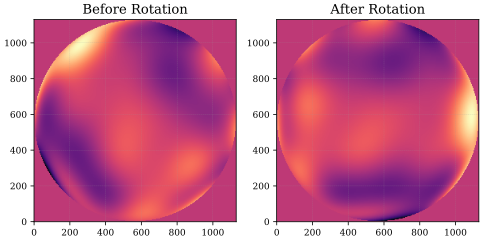

In [11]:
# An example of rotated random map
fig, ax1 = plt.subplots(1,2, figsize=(8,6))
i = 15
lossData = pd.read_csv(f'randommaps/randommap{i}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
lossRotData = pd.read_csv(f'randommaps/randomrot{i}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
ax1[0].imshow(lossData)
ax1[0].set_title('Before Rotation')
ax1[1].imshow(lossRotData)
ax1[1].set_title('After Rotation')
plt.show()

In [28]:
# The loss with rotated random maps applied
kat1 = katHG33.deepcopy()
kat1.parse("""
        pd Pcirc n3
        map ETM Znmmaps/Z22order0phasemap.txt
        """)
kat1.noxaxis = True
out1=kat1.run()
Power=out1["Pcirc"]

pk2=parakat()
for i in range(25):
    katrotation2 = katHG33.deepcopy()
    katrotation2.parse(f"""
            map ETM randommaps/randomrot{i}.txt
            ad AD33 3 3 0 n3
                """)
    katrotation2.noxaxis = True
    pk2.run(katrotation2)
out2 = pk2.getResults()

loss2 = []
for i in range(25):
    loss2.append(1-np.abs(out2[i]['AD33'])**2/Power)

pd.Series(loss2).to_pickle('pkl/rotationrandHG33.pkl')

Parallel jobs: 100%|##########################################################|

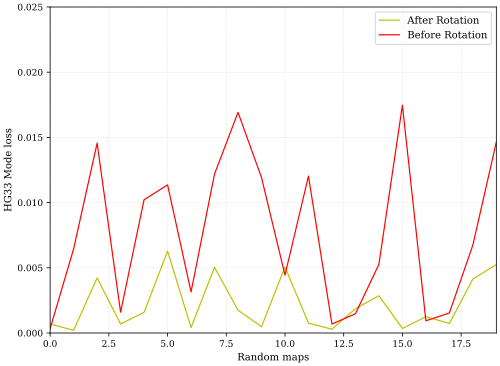

In [4]:
HG33rotloss = pd.read_pickle('../zernikeMapsCrop0.15/pkl/rotationrandHG33.pkl').values
HG33loss = pd.read_pickle('../zernikeMapsCrop0.15/pkl/randomHG33loss.pkl').values # This is done in file 'HG33 and LG22 with randomly generated aLIGO-like maps.ipynb'

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(HG33rotloss[:20],'y',label='After Rotation') # Only plot the first 20 random maps
ax.plot(HG33loss[:20],'r',label='Before Rotation')
ax.set_ylabel("HG33 Mode loss")
ax.set_xlabel("Random maps")
ax.set_ylim(0,0.025)
ax.legend(loc='best')
plt.show()

In [24]:
# # rotate random maps according to Z4-2 and Z42

# # find the Z22 and Z2-2 content and calculate the rotation angle
# Z4_2 = pd.read_csv('Znmmaps/Z4-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
# Z42 = pd.read_csv('Znmmaps/Z42order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

# mapData2 = []
# phiList1 = []
# for ii in range(20):
#     mapData1 = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
#     A4_2 = ((mapData1*Z4_2).sum())/((Z4_2*Z4_2).sum())
#     A42 = ((mapData1*Z42).sum())/((Z42*Z42).sum())

#     phi = np.arctan(A4_2/A42)/2
#     phiList1.append(phi*180/np.pi)
#     radius = 0.15/0.0002669951063580811
#     Data2 = np.zeros((1131, 1131))

#     for i in range(1131):
#         for j in range(1131):
#             if (i-565)**2+(j-565)**2 <= radius**2:
#                 if A42<0:
#                     x = int(round((j-565)*np.cos(phi)+(i-565)*np.sin(phi)))+565
#                     y = int(round(-(j-565)*np.sin(phi)+(i-565)*np.cos(phi)))+565
#                 else:
#                     x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
#                     y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
#                 Data2[i][j] = mapData1[x][y]
#             else:
#                 Data2[i][j] = 0
#     mapfileHeader(f'randommaps/testrandomrot{ii}.txt', Data2)
# #pd.Series(phiList).to_pickle('pkl/testrotationphi.pkl')

In [24]:
# kat1 = katHG33.deepcopy()
# kat1.parse("""
#         pd Pcirc n3
#         map ETM Znmmaps/Z22order0phasemap.txt
#         """)
# kat1.noxaxis = True
# out1=kat1.run()
# Power=out1["Pcirc"]

# pk2=parakat()
# for i in range(14,28):
#     katrotation2 = katHG33.deepcopy()
#     katrotation2.parse(f"""
#             map ETM randommaps/testrandomrot{i}.txt
#             ad AD33 3 3 0 n3
#                 """)
#     katrotation2.noxaxis = True
#     pk2.run(katrotation2)
# out2 = pk2.getResults()

# # loss2 = []
# for i in range(14):
#     loss2.append(1-np.abs(out2[i]['AD33'])**2/Power)

# pd.Series(loss2).to_pickle('pkl/testrotationrandHG33.pkl')

Parallel jobs: 100%|##########################################################|

### Below shows the result of adding astigmatism into the Rcx and Rcy before the rotation

In [6]:
# Need to keep the rotation angle small --> adding more astigmatism
# The rotation angles before and after adding the extra 10nm Z22
phiDF.head(6)

original maps [deg]  with 10nm $Z_{2}^{2}$ [deg]
0           -20.112980                    -0.316478
1           -20.165781                    -0.314738
2            11.384315                    -0.566286
3            -9.874753                     0.382011
4            39.641676                    -0.294092
5            24.364653                    -0.433419

In [29]:
# Rotation angles for 100~500nm of astigmatism
Z2_2 = pd.read_csv('Znmmaps/Z2-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
Z22 = pd.read_csv('Znmmaps/Z22order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

for amp in range(100,600,100):
    phiList = []
    for ii in range(25):
            mapData1 = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
            A2_2 = ((mapData1*Z2_2).sum())/((Z2_2*Z2_2).sum())
            A22 = ((mapData1*Z22).sum())/((Z22*Z22).sum())

            phi = np.arctan(A2_2/(A22+amp))/2 # Add 'amp' amount to A22.
            phiList.append(phi)

    pd.Series(phiList).to_pickle(f'pkl/{amp}nmrotationphi.pkl')

In [8]:
# Rotation angles for {10,20,30,50,80}nm of astigmatism

Z2_2 = pd.read_csv('Znmmaps/Z2-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
Z22 = pd.read_csv('Znmmaps/Z22order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

phi10, phi20 = ([],[])
for amp in [10,20,30,50,80]:
    for ii in range(25):
            mapData1 = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
            A2_2 = ((mapData1*Z2_2).sum())/((Z2_2*Z2_2).sum())
            A22 = ((mapData1*Z22).sum())/((Z22*Z22).sum())

            phi = np.arctan(A2_2/(A22+amp))/2
            eval(f'phi{amp}').append(phi)

np.array(phi10)

array([-0.00552358, -0.00549321, -0.00988355,  0.00666735, -0.00513287,
       -0.00756459,  0.0069028 , -0.0082683 , -0.00915658, -0.00812743,
        0.00174656,  0.00832109,  0.00253629, -0.00554675,  0.00317656,
       -0.00988471, -0.00992229,  0.00940502,  0.01001408, -0.00780753,
       -0.00731846,  0.00740426,  0.01002465,  0.00955813, -0.00624543])

In [11]:
# Apply the angles of rotation to the original random maps to generate the rotated maps
for amp in [10,20,30,50,80]:
    for ii in range(25):
        mapData = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
        Data2 = np.zeros((1131, 1131))
        radius = 0.15/0.0002669951063580811
        phi = eval(f'phi{amp}')[ii]

        for i in range(1131):
            for j in range(1131):
                if (i-565)**2+(j-565)**2 <= radius**2:
                    x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                    y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
                    Data2[i][j] = mapData[x][y]
                else:
                    Data2[i][j] = 0
        mapfileHeader(f'randommaps/{amp}nmRcrotrand{ii}.txt', Data2)
        
        
for amp in range(100,600,100):
    phiList = pd.read_pickle(f'pkl/{amp}nmrotationphi.pkl').values
    for ii in range(25):
        mapData = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
        Data2 = np.zeros((1131, 1131))
        radius = 0.15/0.0002669951063580811
        phi = phiList[ii]

        for i in range(1131):
            for j in range(1131):
                if (i-565)**2+(j-565)**2 <= radius**2:
                    x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                    y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
                    Data2[i][j] = mapData[x][y]
                else:
                    Data2[i][j] = 0
        mapfileHeader(f'randommaps/{amp}nmRcrotrand{ii}.txt', Data2)

In [9]:
# Calculate the loss with the rotated maps applied and also apply the corresponding astigmatism to Rcx and Rcy

kat1 = katHG33.deepcopy()
kat1.parse("""
        pd Pcirc n3
        map ETM Znmmaps/Z22order0phasemap.txt
        """)
kat1.noxaxis = True
out1=kat1.run()
Power=out1["Pcirc"]

for amp in [10,20,30,50,80,100,200,300,400,500]:
    pk2=parakat()
    for ii in range(25):
        katrotation2 = katHG33.deepcopy()
        s = 1/2679.93
        deltas = 0.08889e-6*amp 
        katrotation2.ETM.Rcx = 1/(s+deltas)
        katrotation2.ETM.Rcy = 1/(s-deltas)
        katrotation2.parse(f"""
                map ETM randommaps/{amp}nmRcrotrand{ii}.txt
                ad AD33 3 3 0 n3
                    """)
        katrotation2.noxaxis = True
        pk2.run(katrotation2)
    out2 = pk2.getResults()

    loss2 = []
    for i in range(25):
        loss2.append(1-np.abs(out2[i]['AD33'])**2/Power)
    pd.Series(loss2).to_pickle(f'pkl/{amp}nmRcrot.pkl')

/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

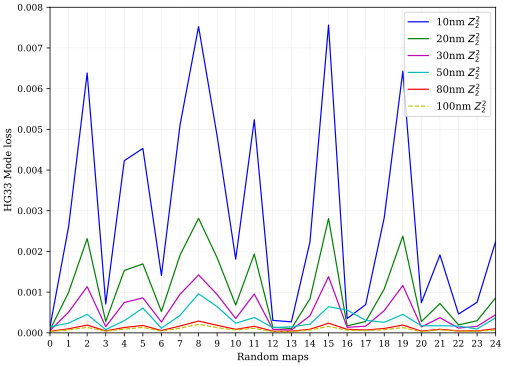

In [6]:
loss10nmRc = pd.read_pickle('pkl/10nmRcrot.pkl').values
loss20nmRc = pd.read_pickle('pkl/20nmRcrot.pkl').values
loss30nmRc = pd.read_pickle('pkl/30nmRcrot.pkl').values
loss50nmRc = pd.read_pickle('pkl/50nmRcrot.pkl').values
loss80nmRc = pd.read_pickle('pkl/80nmRcrot.pkl').values
loss100nmRc = pd.read_pickle('pkl/100nmRcrot.pkl').values

cols=['b', 'g', 'm', 'c', 'r', 'y--']
fig, ax = plt.subplots(figsize=(8,6))

i = 0
for amp in [10,20,30,50,80,100]:
    ax.plot(eval(f'loss{amp}nmRc'), cols[i], label=f'{amp}nm $Z_{2}^{2}$')
    i += 1
ax.set_ylabel("HG33 Mode loss")
ax.set_xlabel("Random maps")
ax.set_ylim(0,0.008)
ax.set_xticks(range(25))
ax.legend(loc='upper right')
plt.show()
fig.savefig('../astigmatismandloss.pdf')

In [3]:
# percentage change of the radius of curvature for 100~500nm of astigmatism
radiusDF = pd.DataFrame()
radiusDF[r'$Z_{2}^{2}$ [nm]'] =list(range(10,100,20))

radius = []
for amp in range(10,100,20):
    s = 1/2679.93
    deltas = 0.0889e-6*amp
    Rcy = 1/(s-deltas)
    radius.append((Rcy-2679.93)/2679.93)
radiusDF[r'($R-R_{0}$)/$R_{0}$'] = radius
radiusDF

$Z_{2}^{2}$ [nm]  ($R-R_{0}$)/$R_{0}$
0                10             0.002388
1                30             0.007199
2                50             0.012056
3                70             0.016960
4                90             0.021912

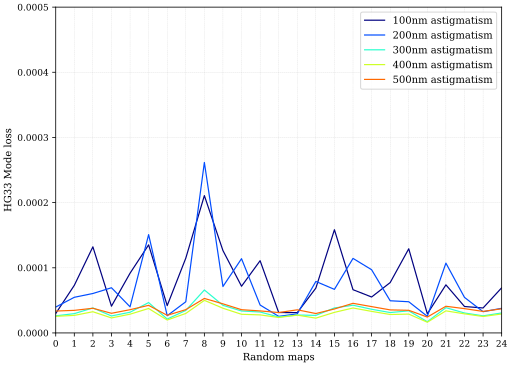

In [6]:
loss10nmRc = pd.read_pickle('pkl/10nmRcrot.pkl').values
loss100nmRc = pd.read_pickle('pkl/100nmRcrot.pkl').values
loss200nmRc = pd.read_pickle('pkl/200nmRcrot.pkl').values
loss300nmRc = pd.read_pickle('pkl/300nmRcrot.pkl').values
loss400nmRc = pd.read_pickle('pkl/400nmRcrot.pkl').values
loss500nmRc = pd.read_pickle('pkl/500nmRcrot.pkl').values

import matplotlib.cm as cm
cols = cm.jet(np.linspace(0,1,6))
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(loss10nmRc[25:],color='r',label='10nm astigmatism')
for amp in range(100,600,100):
    ax.plot(eval(f'loss{amp}nmRc'),color=cols[int(amp/100)-1],label=f'{amp}nm astigmatism')
ax.set_ylabel("HG33 Mode loss")
ax.set_xlabel("Random maps")
ax.set_ylim(0,0.0005)
ax.set_xticks(range(25))
ax.legend(loc='best')
plt.show()
# At astigmatism larger than 100nm, the performance seems random
# Check with higher numerical integration accuracy(1e-4 -> 1e-5) -- no change

In [6]:
# The rotation angles[in arcmin] after adding 400nm of astigmatism 
pd.read_pickle('pkl/400nmrotationphi.pkl')*180*60/np.pi

0    -0.482499
1    -0.479864
2    -0.845801
3     0.564477
4    -0.433627
5    -0.658506
6     0.584654
7    -0.702456
8    -0.780257
9    -0.706536
10    0.153013
11    0.707044
12    0.213819
13   -0.484509
14    0.278097
15   -0.845910
16   -0.849430
17    0.802332
18    0.858268
19   -0.662527
20   -0.620357
21    0.644773
22    0.863344
23    0.826479
24   -0.544999
dtype: float64

### Below is for the contrast defect simulation task, see file 'Contrast defect with rotated maps and more astigmatism.ipynb'

In [4]:
# This block of code is for contrast defect

Z2_2 = pd.read_csv('Znmmaps/Z2-2order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
Z22 = pd.read_csv('Znmmaps/Z22order1phasemap.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

for amp in [10,30,50,100,200,300,400]:
    for ii in range(56):
            mapData = pd.read_csv(f'randommaps/randommap{ii}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
            A2_2 = ((mapData*Z2_2).sum())/((Z2_2*Z2_2).sum())
            A22 = ((mapData*Z22).sum())/((Z22*Z22).sum())

            phi = np.arctan(A2_2/(A22+amp))/2

            Data = np.zeros((1131, 1131))
            radius = 0.15/0.0002669951063580811

            for i in range(1131):
                for j in range(1131):
                    if (i-565)**2+(j-565)**2 <= radius**2:
                        if A22<0:
                            x = int(round((j-565)*np.cos(phi)+(i-565)*np.sin(phi)))+565
                            y = int(round(-(j-565)*np.sin(phi)+(i-565)*np.cos(phi)))+565
                        else:
                            x = int(round((i-565)*np.cos(phi)+(j-565)*np.sin(phi)))+565
                            y = int(round(-(i-565)*np.sin(phi)+(j-565)*np.cos(phi)))+565
                        Data[i][j] = mapData[x][y]
                    else:
                        Data[i][j] = 0

            mapfileHeader(f'randommaps/{amp}nmCDrandommap{ii}.txt', Data)